In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from os import listdir
from scipy.ndimage import shift


plt.style.use('C:\Users\jimmy\OneDrive\Astron100\Day1\Comp\0050.COMP_RXJ.fits')
%config InlineBackend.figure_format='retina'

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (4233588259.py, line 9)

In [11]:

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Define the directory and file patterns
directory = 'data/'
bias_file_pattern = 'BIAS'
flat_file_pattern = 'FLAT'

# Specific file numbers to include
bias_numbers = {'0021','0022','0023', '0024','0025','0026','0027','0028','0029','0030','0031','0032','0033','0034','0035','0036','0037','0039','0038','0040'}
flat_numbers = {'0001','0002','0003','0004', '0005','0006', '0007', '0008','0009','0010','0011','0012','0013','0014','0015','0016','0017','0018','0019','0020'}

# List and filter all files in the directory
all_files = os.listdir(directory)
bias_files = [file for file in all_files if bias_file_pattern in file and any(num in file for num in bias_numbers)]
flat_files = [file for file in all_files if flat_file_pattern in file and any(num in file for num in flat_numbers)]
print(flat_files)

# Load and trim the top BIAS files
bias_data = []
for file in bias_files:
    file_path = os.path.join(directory, file)
    with fits.open(file_path) as hdul:
        trimmed_data = hdul[0].data[:, :]  # Trim each bias file
        bias_data.append(trimmed_data)

# Combine all bias data by taking the median
combined_bias = np.median(np.array(bias_data), axis=0)

# Load and combine the top FLAT files, normalized and trimmed
flat_data = []
for file in flat_files:
    file_path = os.path.join(directory, file)
    with fits.open(file_path) as hdul:
        trimmed_flat_data = hdul[0].data[:, :]  # Apply trimming
        flat_data.append(trimmed_flat_data / np.mean(trimmed_flat_data))

# Combine all flat data by taking the median
combined_flat = np.median(np.array(flat_data), axis=0)

# Combine all flat data by taking the median across the array
combined_flat = np.median(np.array(flat_data), axis=0)

# Prepare pixel range for trimmed data
pixels = np.arange(0, combined_flat.shape[-1])

# Calculate the mean flat for polynomial fitting
mean_flat = np.mean(combined_flat, axis=0)

# Iteratively find the best polynomial degree (without weighting)
min_residual = np.inf
best_degree = 0

for degree in range(1, 10):  # Test polynomial degrees from 1 to 9
    p = np.polynomial.Polynomial.fit(pixels, mean_flat, degree)
    poly_fit = p(pixels)
    residual = np.sum((mean_flat - poly_fit) ** 2)  # Sum of squared residuals

    if residual < min_residual:
        min_residual = residual
        best_degree = degree

# Use the best degree found
p_best = np.polynomial.Polynomial.fit(pixels, mean_flat, best_degree)
poly_fit_best = p_best(pixels)

# Normalize the flat field
normalized_flat = combined_flat / (mean_flat / poly_fit_best)


# Function to process science images with bias subtraction, flat correction, and trimming
def process_science_image(science_file, combined_bias, combined_flat):
    with fits.open(science_file) as hdul:
        # Trim the science image to match the bias and flat dimensions
        science_image = hdul[0].data[:, :]

        # Subtract bias and apply flat-field correction
        bias_subtracted_image = science_image - combined_bias
        flat_corrected_image = bias_subtracted_image / combined_flat

        return flat_corrected_image, science_image


# Visualization for combined bias and flat frames
def plot_bias_and_flat(combined_bias, combined_flat):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(combined_bias, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar()
    plt.title('Combined Bias Frame')

    plt.subplot(1, 2, 2)
    plt.imshow(combined_flat, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar()
    plt.title('Combined Flat Frame')

    plt.show()


# Function to raw plot 1D spectrum from a specific region in the image
def plot_1d_spectrum_raw(image_data, y_start=80, y_end=88):
    spectrum_1d = np.sum(image_data[y_start:y_end], axis=0)

    # Plot the extracted 1D spectrum
    plt.figure(figsize=(10, 4))
    plt.plot(np.arange(len(spectrum_1d)), spectrum_1d, color='black')
    plt.title('Extracted 1D Spectrum')
    plt.xlabel('X Pixel')
    plt.ylabel('Summed Intensity')
    plt.show()

# Function to plot 1D spectrum from a specific region in the image
def plot_1d_spectrum(image_data, y_start=80, y_end=88):
    spectrum_1d = np.sum(image_data[y_start:y_end], axis=0)

    # Plot the 2D science image with highlighted region
    plt.figure(figsize=(12, 4))
    plt.imshow(image_data, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Intensity')
    plt.axhline(y=y_start, color='red', linestyle='--', label='Extraction Start')
    plt.axhline(y=y_end, color='red', linestyle='--', label='Extraction End')
    plt.title('Science Image with Spectrum Extraction Region')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.ylim(78,100)
    plt.legend()
    plt.show()

    # Plot the extracted 1D spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(spectrum_1d)), spectrum_1d, color='black')
    plt.title('Extracted 1D Spectrum')
    plt.xlabel('X Pixel')
    plt.ylabel('Summed Intensity')
    plt.show()

# Function to visualize raw and corrected science images
def plot_science_images(raw_image, corrected_image):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(raw_image, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar()
    plt.ylim(80,100)
    plt.title('Raw Science Image')

    plt.subplot(1, 2, 2)
    plt.imshow(corrected_image, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar()
    plt.ylim(80,100)
    plt.title('Corrected Science Image')

    plt.show()

science_file = os.path.join("data/0065.HD84937.fits")

plot_bias_and_flat(combined_bias, combined_flat)

# corrected_science_image, raw_science_image = process_science_image(science_file, combined_bias, combined_flat)
# plot_science_images(raw_science_image, corrected_science_image)



FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data/'

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import find_peaks

# Define the directory and specific file
directory = 'data/'
#comp_file = 'C:/Users/jimmy/OneDrive/Astron100/Day1/Comp/0050.COMP_RXJ.fits'  # Specify the COMP file you want to process

# Load the COMP file (before calibration)
comp_file_path = 'C:/Users/jimmy/OneDrive/Astron100/Day1/Comp/0052.COMP_OJ287.fits'
with fits.open(comp_file_path) as hdul:
    comp_data_raw = hdul[0].data

    print(f"\nViewing FITS file: {comp_file_path}")
    print("Header:")
    print(repr(hdul[0].header))
    print("\nData shape:")
    print(hdul[0].data.shape)

# Trim the raw data (same trimming as for bias and flat)
comp_data_trimmed = comp_data_raw[:, :]

# Normalize and subtract bias (using combined bias data)
bias_subtracted_comp = comp_data_trimmed - combined_bias

# Trim both the bias-subtracted COMP data and the normalized flat to match the smaller size
min_width = min(bias_subtracted_comp.shape[1], normalized_flat.shape[1])

bias_subtracted_comp_trimmed = bias_subtracted_comp[:, :min_width]
normalized_flat_trimmed = normalized_flat[:, :min_width]

# Apply flat correction (normalize by combined flat)
calibrated_comp = bias_subtracted_comp_trimmed / normalized_flat_trimmed

# Plot the raw, trimmed, and calibrated COMP image
fig, axs = plt.subplots(1, 1, figsize=(12, 4))

# Display the calibrated COMP file
axs.imshow(calibrated_comp, cmap='gray', origin='lower', aspect='auto')
axs.set_title('Calibrated COMP File (After Calibration)')
axs.set_xlabel('X Pixel')
axs.set_ylabel('Y Pixel')

plt.tight_layout()
plt.show()

# Create a 1D spectrum by summing over the spatial dimension (Y-axis)
comp_spectrum_1d = np.sum(calibrated_comp, axis=0)




Viewing FITS file: C:/Users/jimmy/OneDrive/Astron100/Day1/Comp/0052.COMP_OJ287.fits
Header:


ValueError: FITS header values must contain standard printable ASCII characters; "'2000\r             ' / EPOCH" contains characters not representable in ASCII or non-printable characters.

68


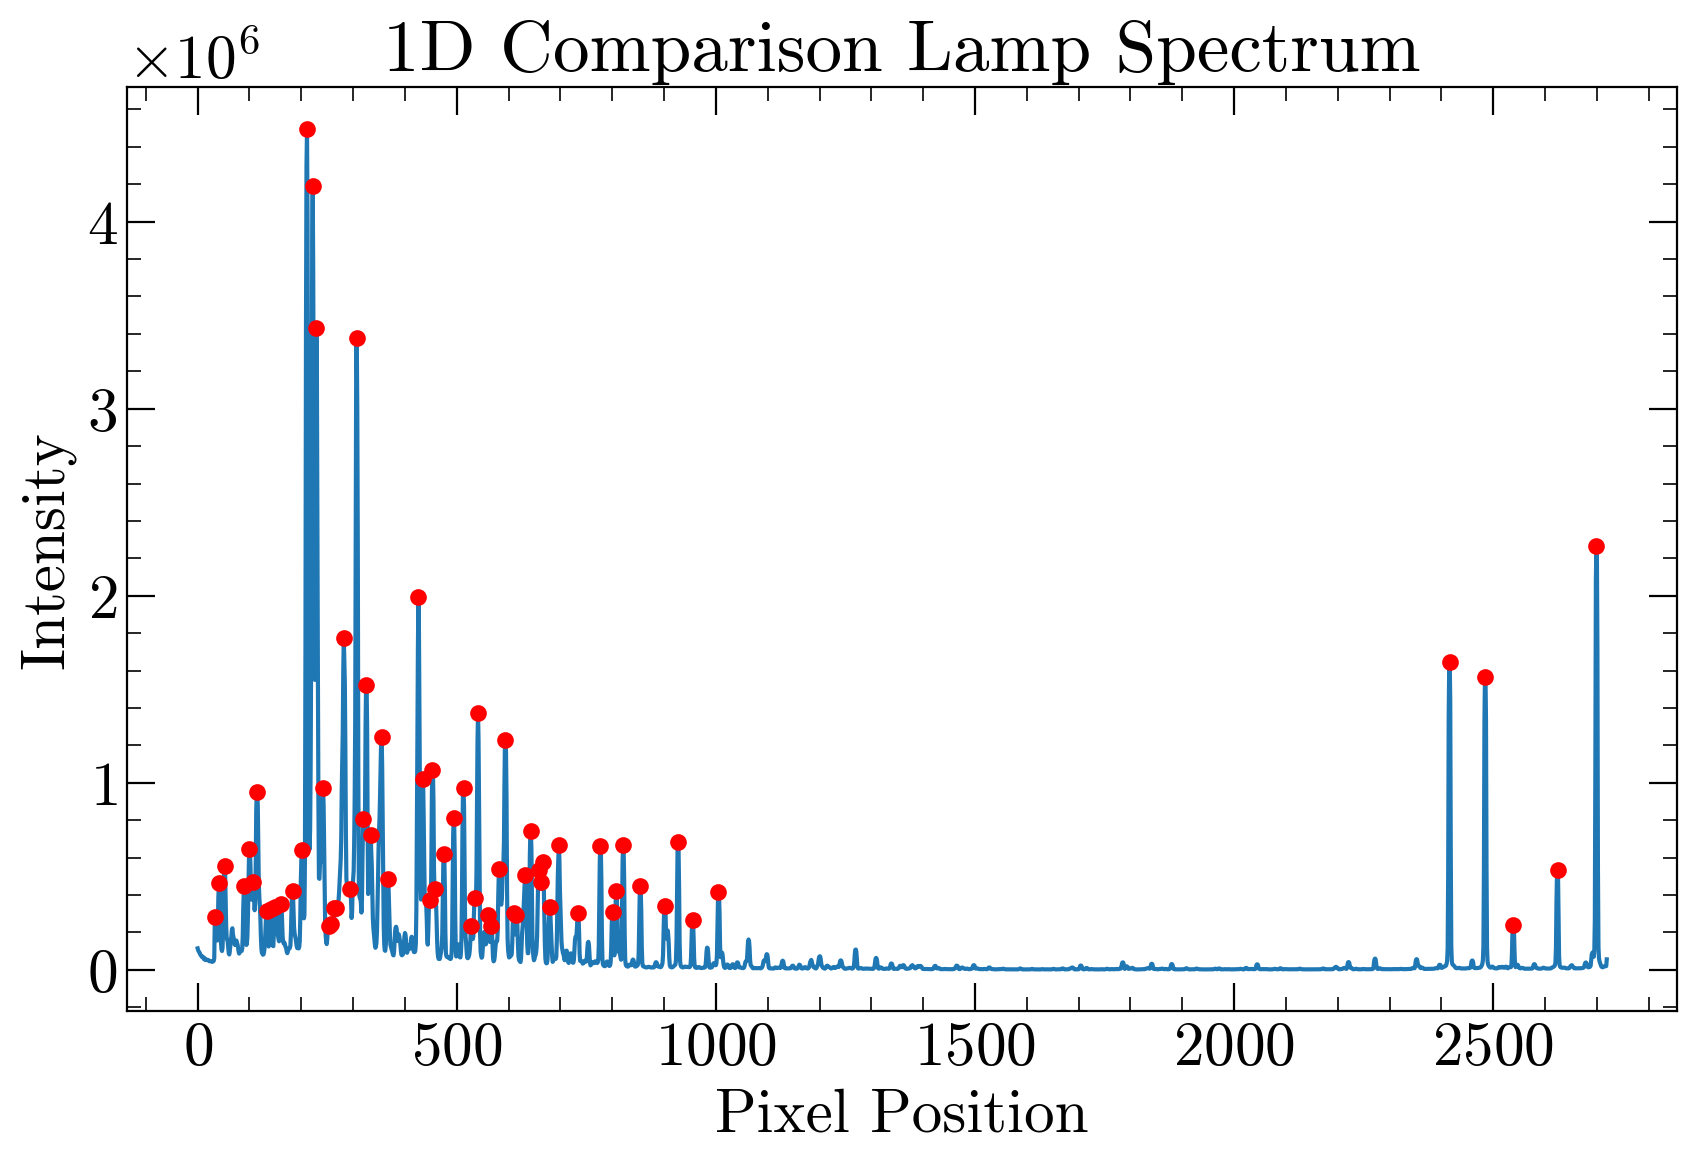

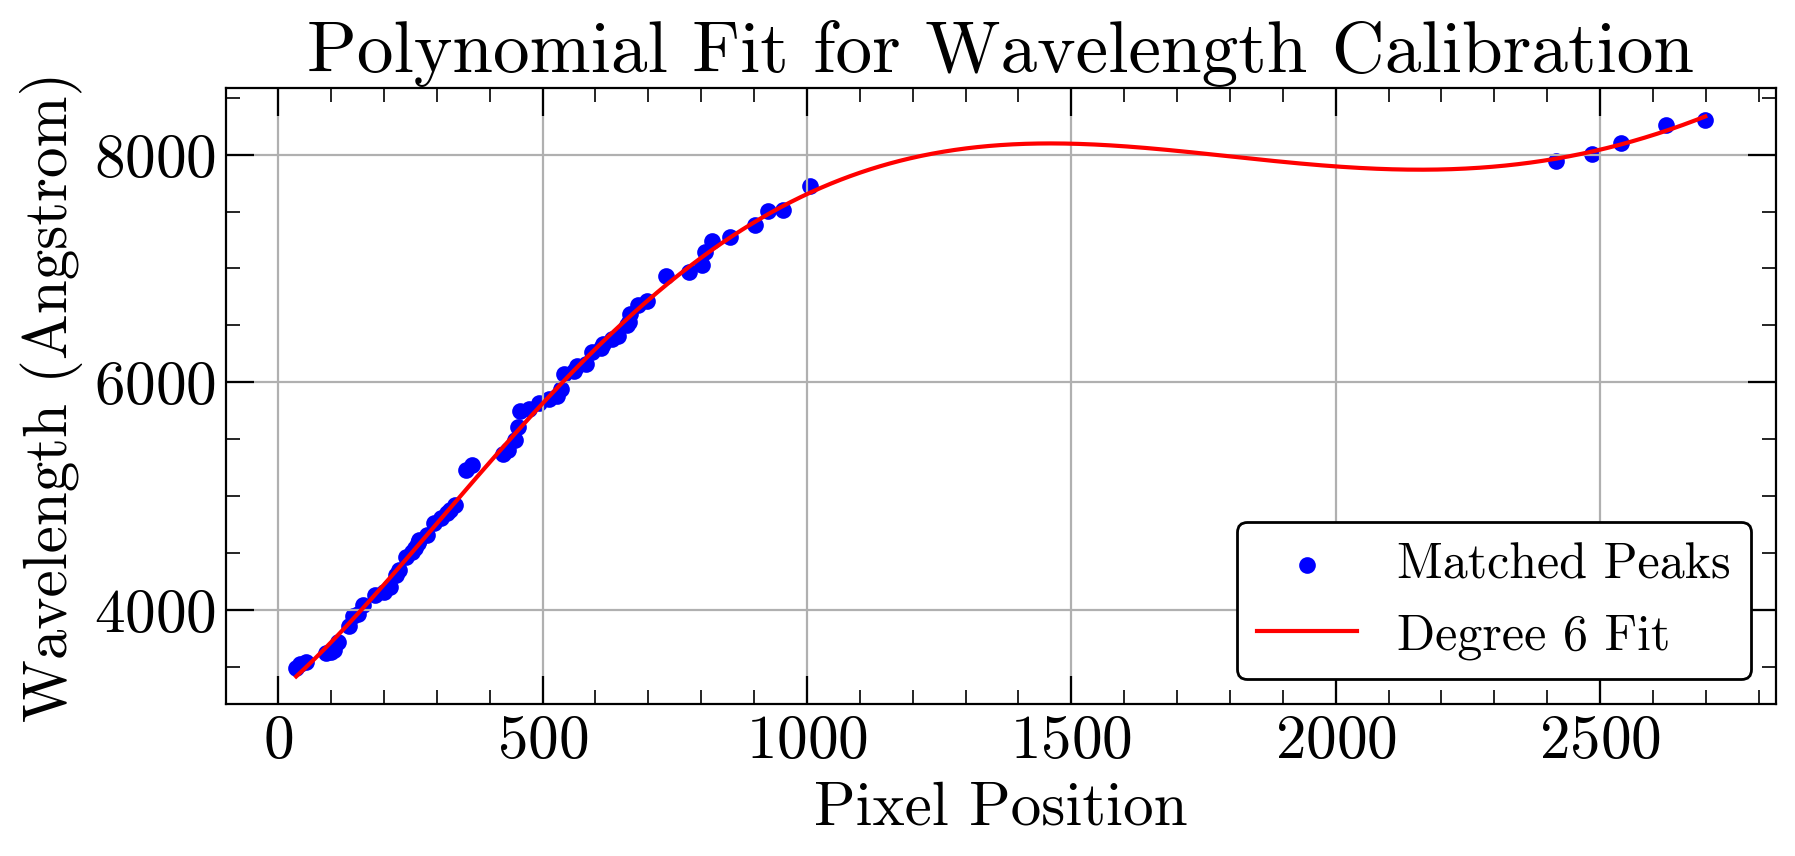

In [693]:
from numpy.polynomial import Polynomial
from scipy.signal import find_peaks

peaks, properties = find_peaks(comp_spectrum_1d)

# Sort peaks by intensity and select the 10 most intense peaks
peak_intensities = properties['peak_heights'] = comp_spectrum_1d[peaks]
top_peaks_idx = np.argsort(peak_intensities)[-68:]  # Indices of the 10 highest peaks
top_peaks = peaks[top_peaks_idx]  # Pixel positions of the 10 highest peaks
top_peaks_intensity = comp_spectrum_1d[top_peaks]  # Intensities of the 10 highest peaks

sorted_peak_pixels = np.sort(top_peaks)
sorted_known_wavelengths = np.sort(wavelengths)

print(len(sorted_peak_pixels))


# Plot the 1D comparison spectrum with the 10 most intense peaks marked
plt.figure(figsize=(10, 6))
plt.plot(comp_spectrum_1d, label='Comparison Spectrum')
plt.plot(top_peaks, top_peaks_intensity, 'ro', label='Top 10 Intense Peaks')
plt.xlabel('Pixel Position')
plt.ylabel('Intensity')
plt.title('1D Comparison Lamp Spectrum')



# 3. Fit a polynomial (linear or quadratic depending on distortion)
fit_poly = Polynomial.fit(sorted_peak_pixels, sorted_known_wavelengths, deg=6)  # Use deg=2 if needed

# 4. Apply the mapping to convert pixels to wavelengths
pixel_indices = np.arange(len(comp_spectrum_1d))
calibrated_wavelengths = fit_poly(pixel_indices)

plt.figure(figsize=(10, 4))

# Scatter of known data points
plt.scatter(sorted_peak_pixels, sorted_known_wavelengths, color='blue', label='Matched Peaks')

# Polynomial fit curve
x_fit = np.linspace(min(sorted_peak_pixels), max(sorted_peak_pixels), 1000)
y_fit = fit_poly(x_fit)
plt.plot(x_fit, y_fit, color='red', label=f'Degree {fit_poly.degree()} Fit')

plt.xlabel("Pixel Position")
plt.ylabel("Wavelength (Angstrom)")
plt.title("Polynomial Fit for Wavelength Calibration")
plt.grid(True)
plt.legend()
plt.show()


In [842]:
def plot_wavelength_pixel_solution(
    spectrum, pixel_positions, wavelength_values, wavelength_labels=None, annotate=True, 
    figsize=(12, 5), invert_x=False, xlim=None, ylim=None
):

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(spectrum*150, label='1D Spectrum')
    ax.set_xlabel("Pixel Position")
    ax.set_ylabel("Intensity")
    ax.set_title("1D Spectrum with Known Line Positions")
    ax.grid(True)

    for i, pix in enumerate(pixel_positions):
        wl = wavelength_values[i]
        label = f"{wl:.1f} "
        if wavelength_labels is not None:
            label += f" ({wavelength_labels[i]})"
        ax.axvline(pix, color='red', linestyle='--', alpha=0.5)
        if annotate:
            ax.text(pix, spectrum[int(pix)] -2000000, label, 
                    rotation=90, ha='right', va='bottom', fontsize=12, color='red')

    if invert_x:
        ax.invert_xaxis()
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)

    plt.tight_layout()
    plt.show()


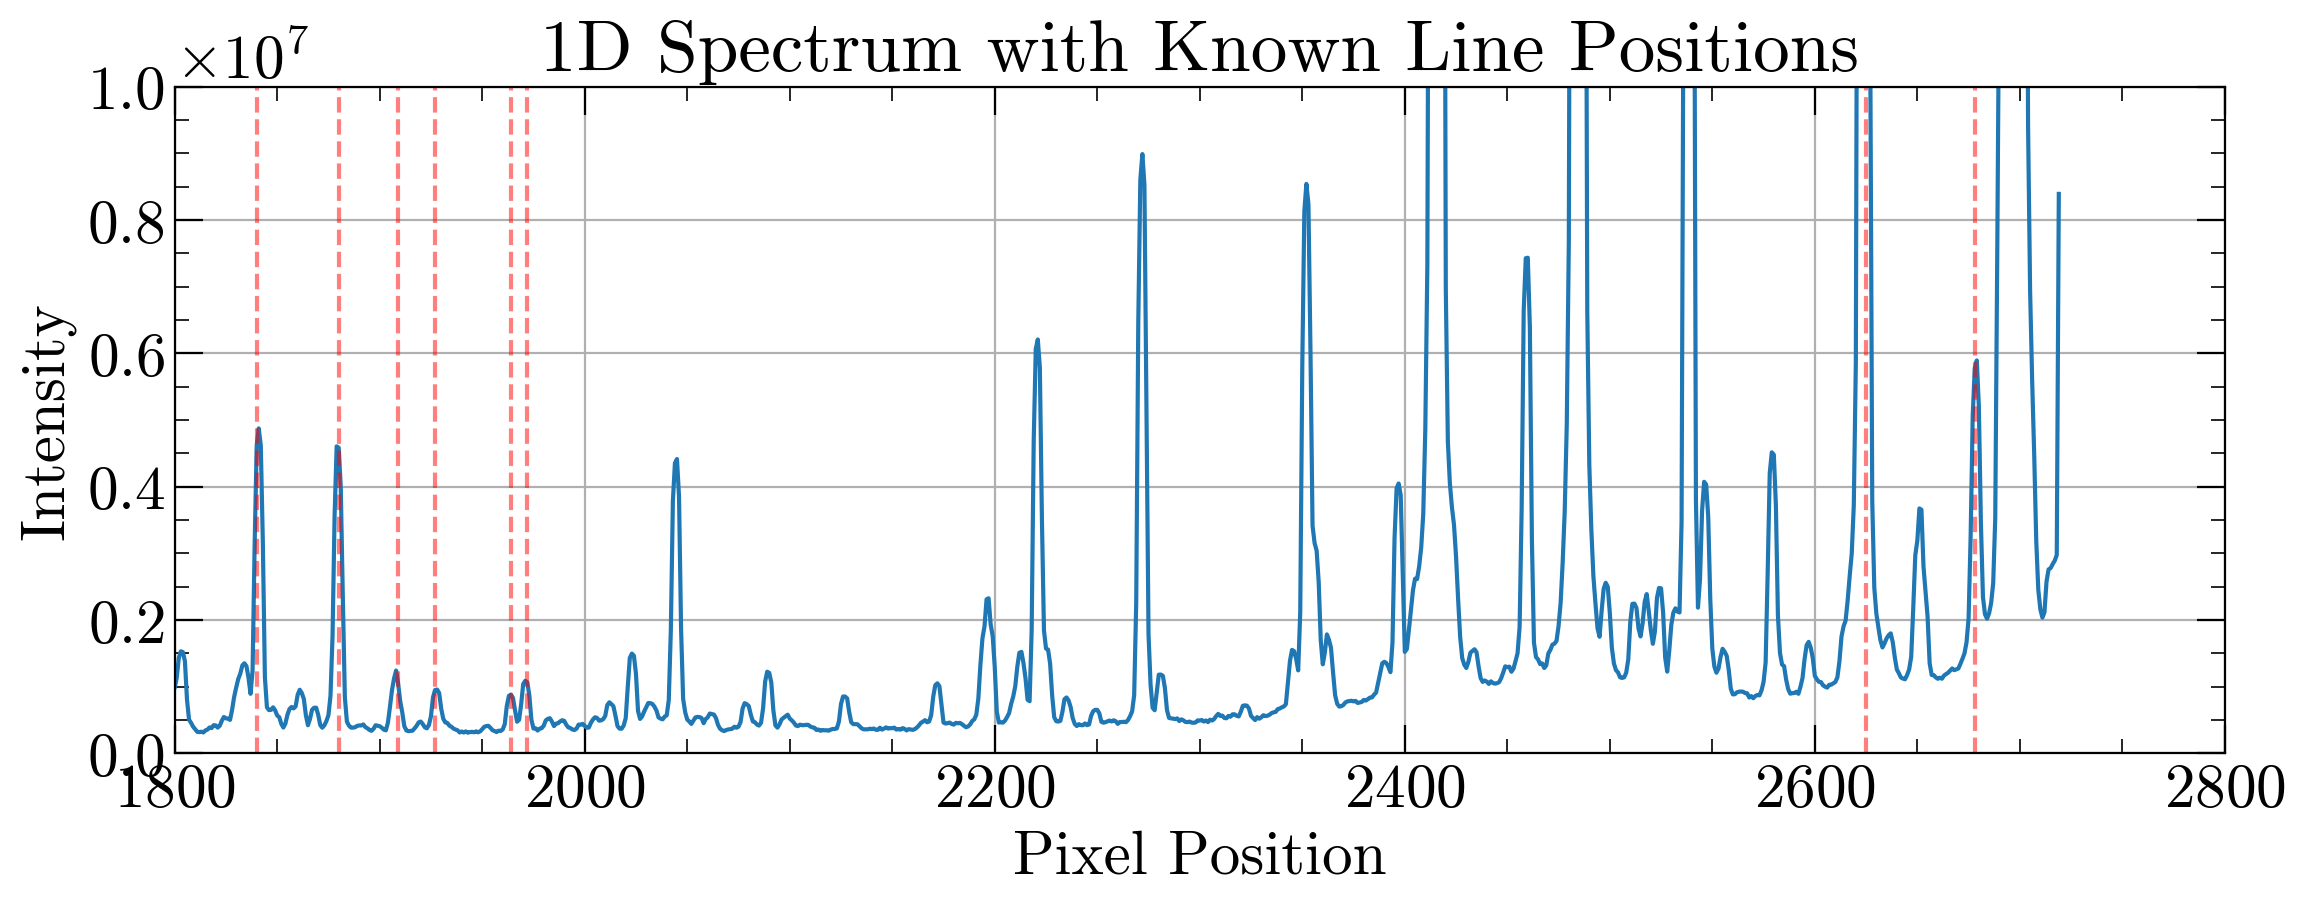

In [843]:
pixels_solution = np.array([210, 306, 435, 495, 512,540, 643,755,777,808,822,927,955,985,1005,1240,1270,1338,1422,
                            1497,1785, 1793,1840,1880,1909,1927,1964,1972,2625,2678])
wavelength_solution = np.array([3719.935, 3859.400, 4045.450,4131.830, 4158.590, 4199.860, 4348.064,4510.733, 
                                4545.080, 4589.900, 4609.560,4764.890, 4806.070,4847.820,4879.900, 5227.300,
                                5269.650,5371.489,5496.210, 5606.732,6074.338,6096.1630,6163.594,6266.495,
                               6304.850,6334.428,6382.991 ,6402.246,6965.4300,7032.4127 ])#7383.980, 7514.651])
wavelength_label = np.array(["FeI", "FeI", "FeI" ,"ArII","ArI", "ArI","FeI", "ArII", "ArII", "AII","AII","AII","AII", 
                             "AII","AII","AII", "AII","FeI","FeI","FeI", "AI","NeI","NeI","NeI","NeI","NeI","NeI",
                            "NeI","NeI","AI"])

plot_wavelength_pixel_solution(
    comp_spectrum_1d, 
    pixels_solution, 
    wavelength_solution, 
    wavelength_labels=wavelength_label,
    annotate=False, 
    invert_x=False,
    xlim=(1800,2800),
    ylim=(0,10e6)
)


Polynomial coefficients: [-1.68082138e-07  6.07623032e-04  8.74859881e-01  3.55690966e+03]


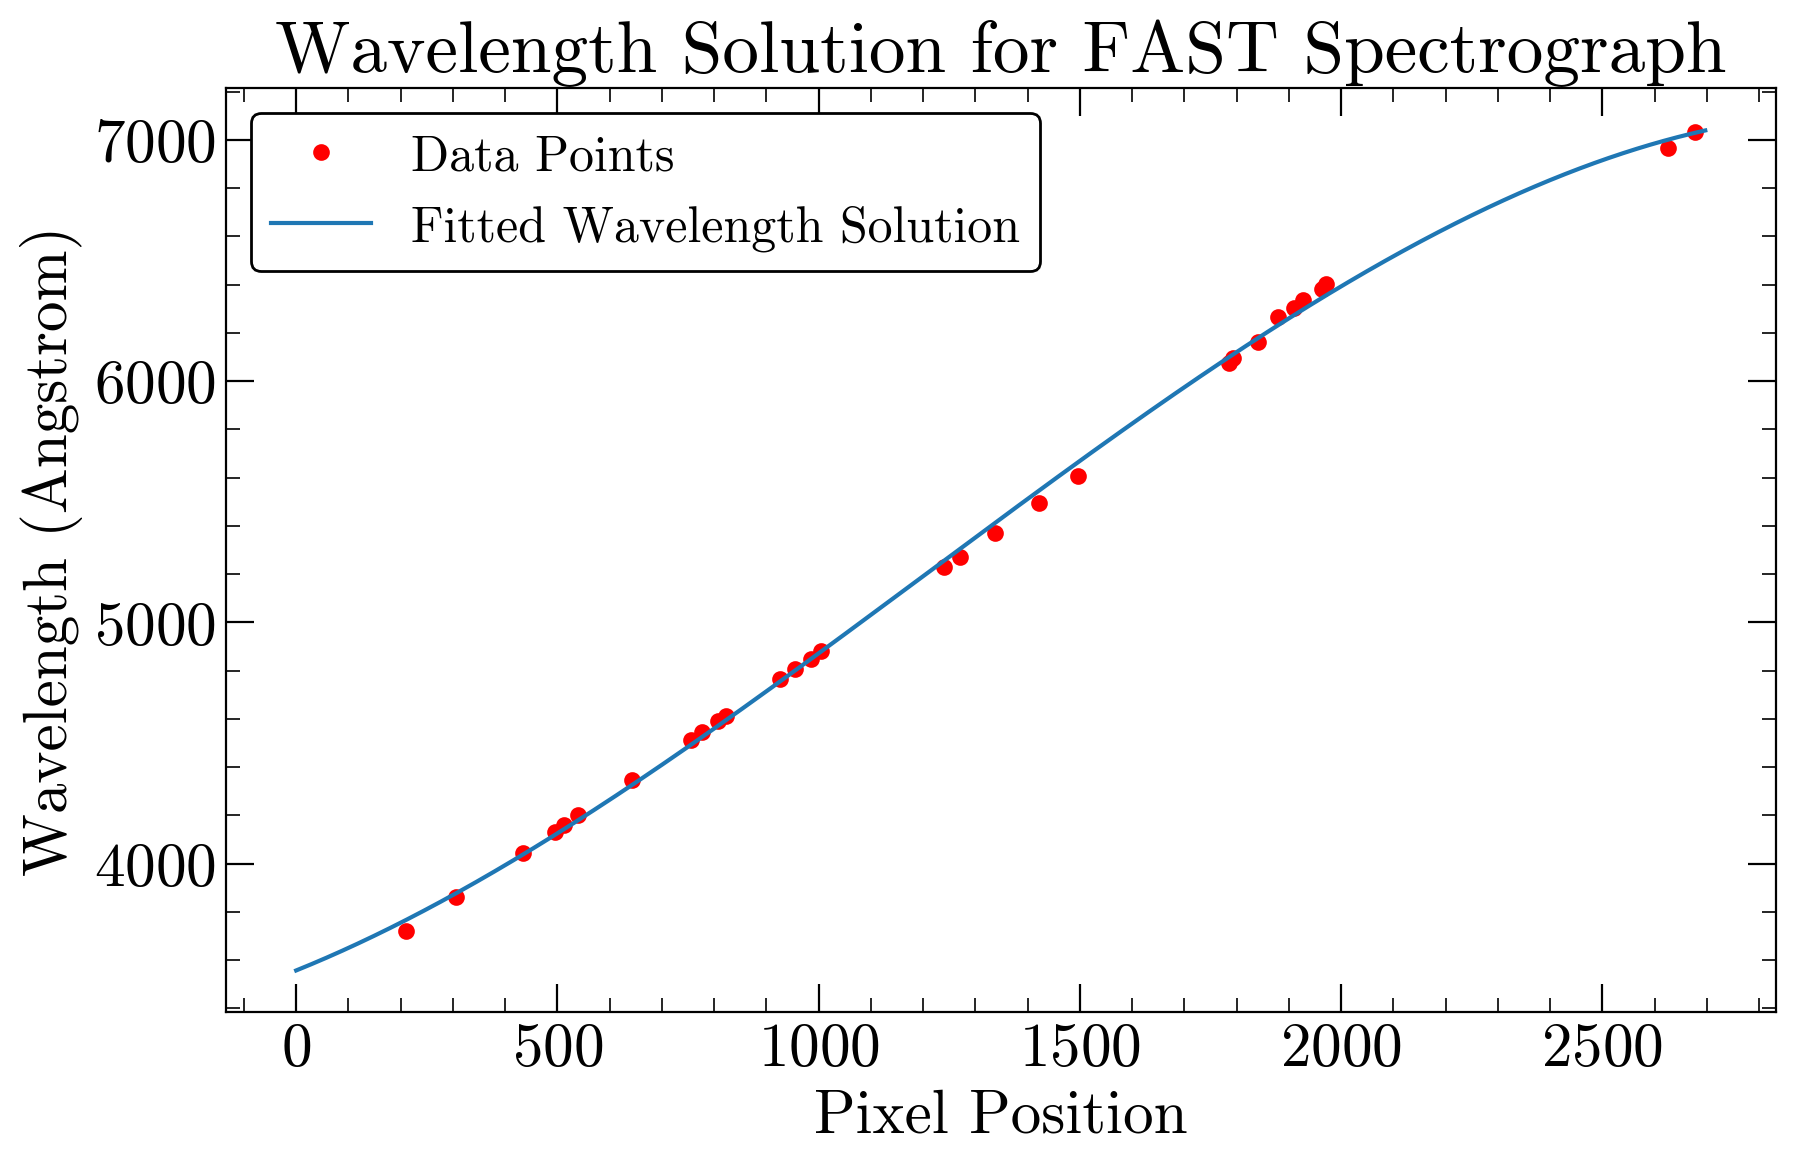

In [851]:


# Define a polynomial function to fit the data
def polynomial(x, a, b, c, d):
    return  a * x**3 + b * x**2 + c * x + d

# Fit the polynomial to the data
popt, pcov = curve_fit(polynomial, pixels_solution, wavelength_solution,)
a, b, c, d = popt

# Print out the polynomial coefficients
print("Polynomial coefficients:", popt)

# Generate wavelengths using the polynomial solution across the full pixel range
pixel_range = np.arange(0, max(pixels_solution) +20)
calibrated_wavelengths = polynomial(pixel_range, *popt)

# Plot the original data points and the fitted polynomial solution
plt.figure(figsize=(10, 6))
plt.plot(pixels_solution, wavelength_solution, 'ro', label='Data Points')
plt.plot(pixel_range, calibrated_wavelengths, label='Fitted Wavelength Solution')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (Angstrom)')
plt.title('Wavelength Solution for FAST Spectrograph')
plt.legend()
plt.show()

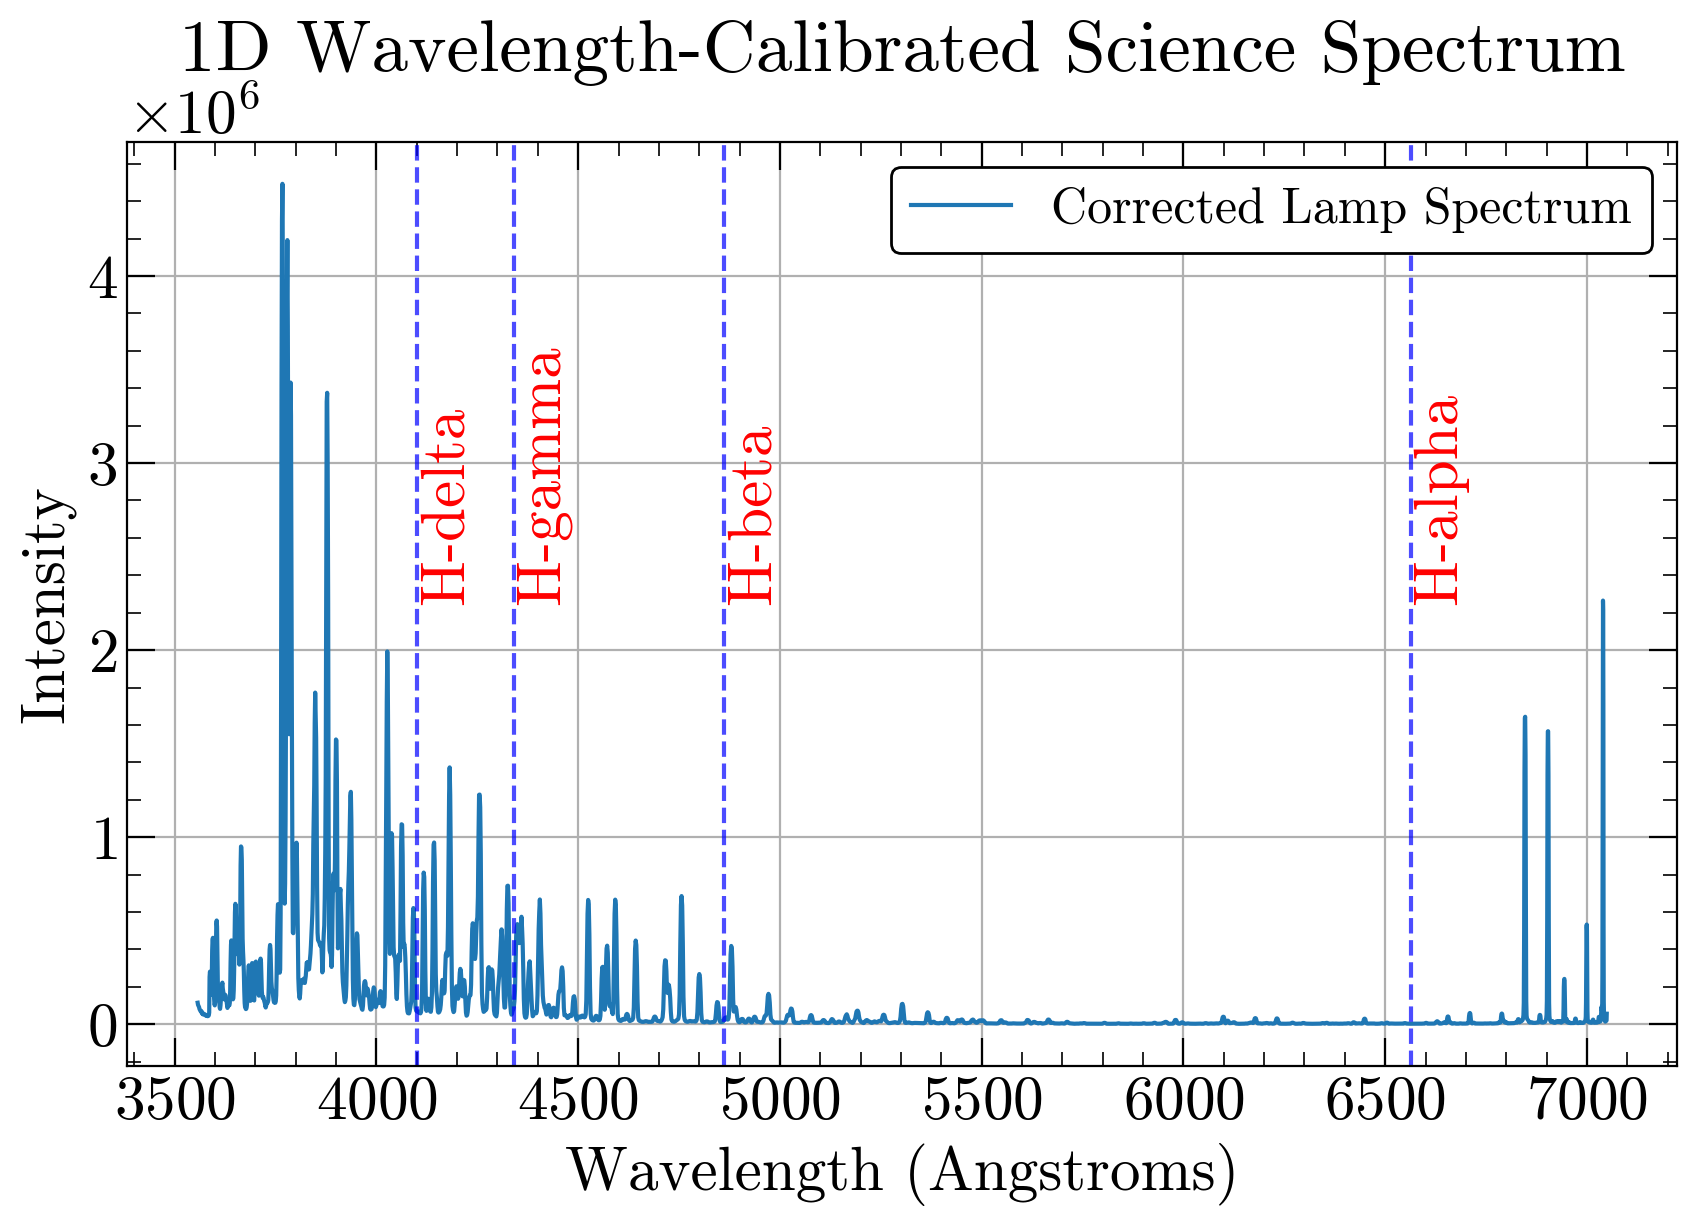

In [853]:

coeffs = [a, b, c, d]  # Replace a, b, c, d with the values from your polynomial fit

def apply_wavelength_solution(pixels, coeffs):
    return np.polyval(coeffs, pixels)



science_file = os.path.join("data/0065.HD84937.fits")
#science_file = os.path.join("data/0041.SN2024aefa.fits")

corrected_science_image, raw_science_image = process_science_image(science_file, combined_bias, combined_flat)
science_spectrum_1d = np.sum(corrected_science_image, axis=0)
pixels = np.arange(len(comp_spectrum_1d))

wavelength_solution_adjusted = apply_wavelength_solution(pixels, coeffs)
wavelength_solution_adjusted_science = apply_wavelength_solution(pixels, coeffs)

# Define only the H-alpha spectral line
lines = {
    'H-alpha': 6563,
    'H-beta': 4861,
    'H-gamma': 4340,
    'H-delta': 4101
}

def plot_1d_spectrum_with_lines(wavelengths, spectrum_1d):
    plt.figure(figsize=(10, 6))

    # Plot the 1D spectrum
    plt.plot(wavelengths, spectrum_1d, label='Corrected Lamp Spectrum')
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Intensity')
    plt.title('1D Wavelength-Calibrated Science Spectrum')
    plt.grid(True)

    # Plot the vertical line for the H-alpha line
    for line_name, line_wavelength in lines.items():
        plt.axvline(x=line_wavelength, color='blue', linestyle='--', alpha=0.7)
        plt.text(line_wavelength +5, np.max(spectrum_1d) * 0.5, line_name, rotation=90, verticalalignment='bottom', color='red')

    plt.legend()
    plt.show()

# Plot the 1D spectrum with only the H-alpha line using the wavelength solution
plot_1d_spectrum_with_lines(wavelength_solution_adjusted, comp_spectrum_1d)


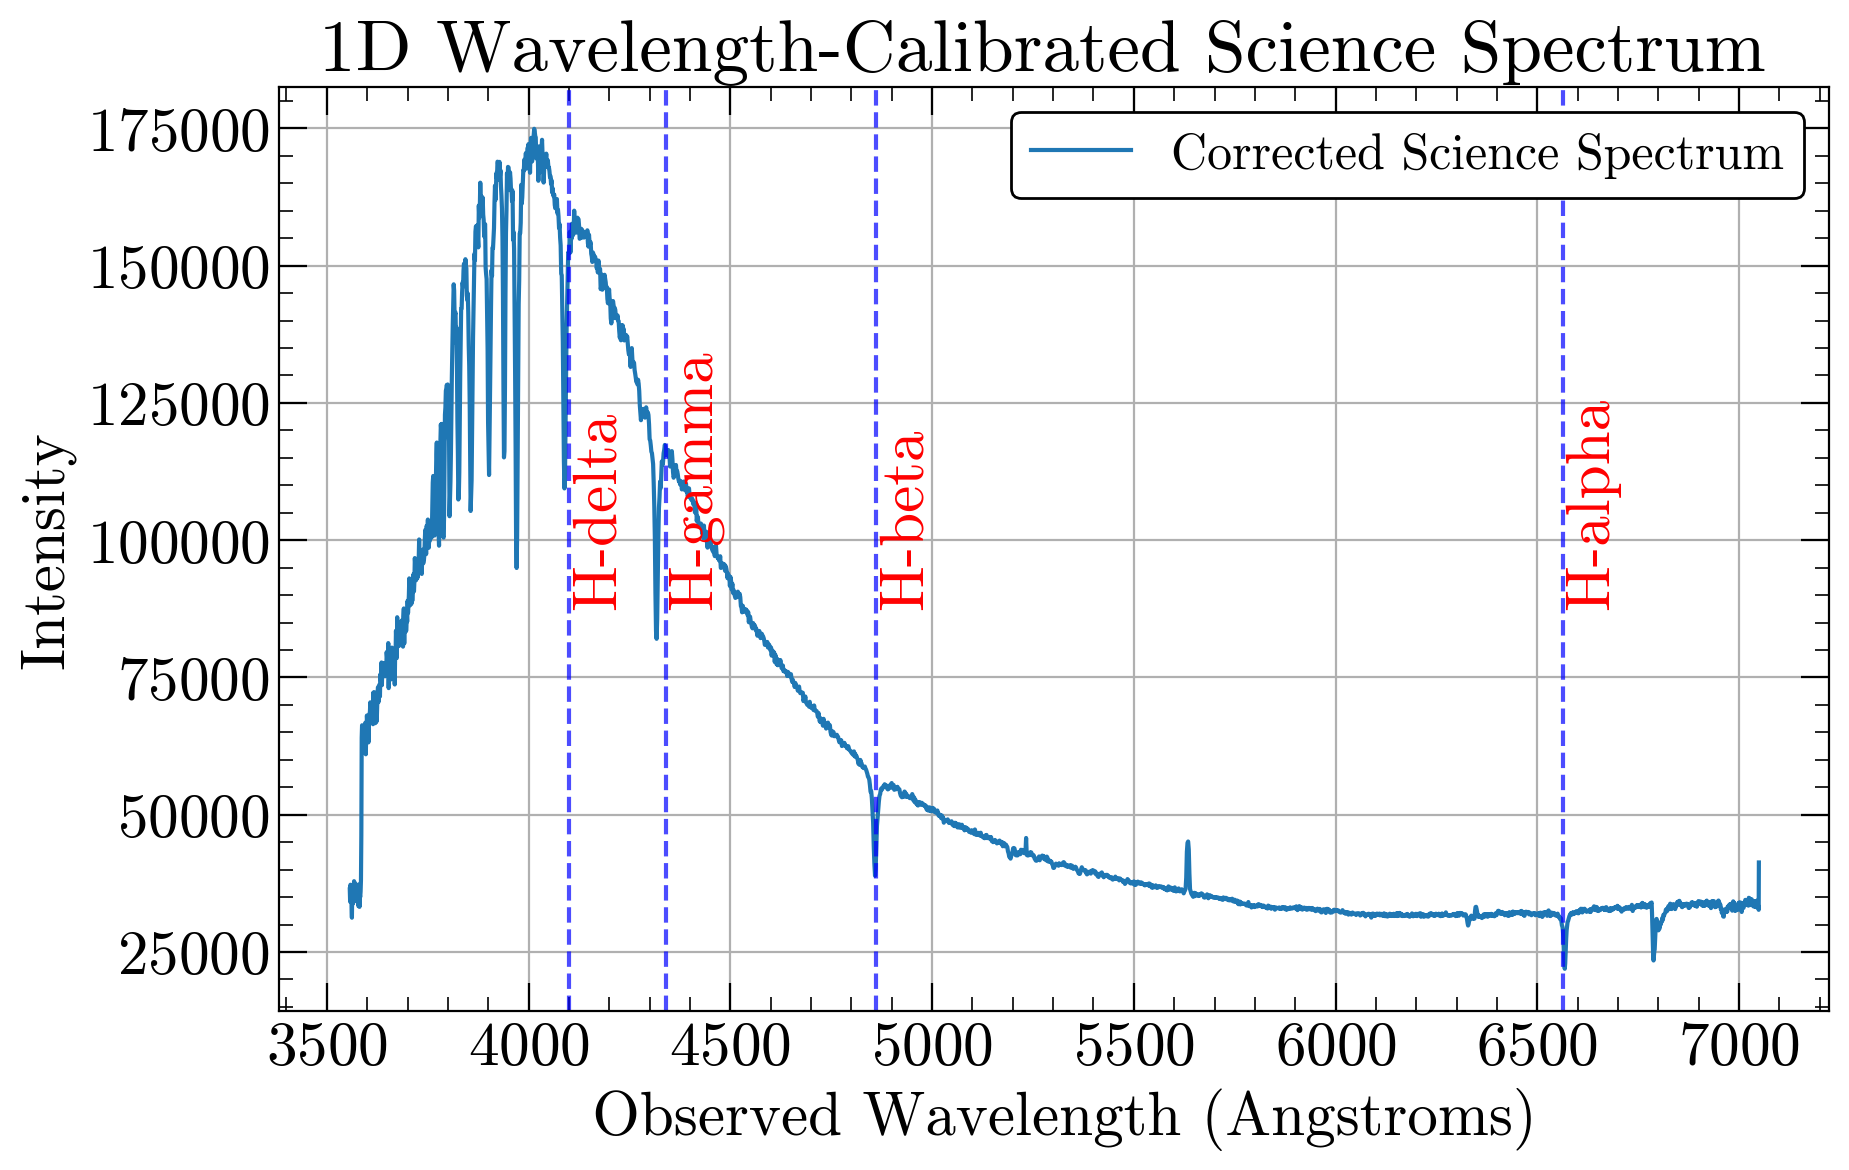

In [854]:

def plot_1d_spectrum_with_lines(wavelengths, spectrum_1d):
    plt.figure(figsize=(10, 6))

    # Plot the 1D spectrum
    plt.plot(wavelengths, spectrum_1d, label='Corrected Science Spectrum')
    plt.xlabel(' Observed Wavelength (Angstroms)')
    plt.ylabel('Intensity')
    plt.title('1D Wavelength-Calibrated Science Spectrum ')
    plt.grid(True)

    # Plot the vertical line for the H-alpha line
    for line_name, line_wavelength in lines.items():
        plt.axvline(x=line_wavelength, color='blue', linestyle='--', alpha=0.7)
        plt.text(line_wavelength +5, np.max(spectrum_1d) * 0.5, line_name, rotation=90, verticalalignment='bottom', color='red')

    plt.legend()
    plt.show()


plot_1d_spectrum_with_lines(wavelength_solution_adjusted_science, science_spectrum_1d)